<a href="https://colab.research.google.com/github/t080/jawikinews-headline-dataset/blob/master/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construct a Japanese-Wikinews Headline Dataset


## Settings

In [1]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title Setup Environment
!pip install --quiet mojimoji
!pip install --quiet tqdm
!pip install --quiet nltk

!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install --quiet mecab-python3==0.7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp-date-perl
  libhttp-message-perl libio-html-perl libio-string

In [0]:
#@title Setup common imports and functions
import json
import gzip
import os
import re
import nltk
import MeCab
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import mojimoji


mecab = MeCab.Tagger('-O wakati')
starts_pattern = re.compile(r'【[0-9年月日 ]+】')
wikipedia_pattern = re.compile(r'^ウィキペディアに.*に関する記事があります。')


def count_lines(path):
    with gzip.open(path, 'r') as f:
        return sum([1 for _ in f])

## Preprocessing of Japanese Wikinews

In [0]:
# Functions
def preprocess(json_line, use_start_pattern=True, is_document=True):
    json_line = json_line.rstrip().replace('\u3000', '').replace(' ', '')
    json_line = mojimoji.zen_to_han(json_line, kana=False)

    if is_document:
        if use_start_pattern:
            if starts_pattern.search(json_line) is None:
                return None
            json_line = json_line[starts_pattern.search(json_line).end():]
        
            if use_start_pattern and wikipedia_pattern.search(json_line) is not None:
                json_line = json_line[wikipedia_pattern.search(json_line).end():]            
            
        sents = re.split(r'。', json_line)         
        while '' in sents:
            sents.pop(sents.index(''))
        tokenized = ' '.join(['<s> ' + mecab.parse(sent).rstrip() + '。 </s>' for sent in sents])
    else:
        tokenized = '<s> ' + mecab.parse(json_line).rstrip() + ' </s>'
    return tokenized

In [5]:
# Preprocess
data_path = "/content/drive/My Drive/wikinews-headline/jawikinews-20190909-cirrussearch-content.json.gz"
preprocessed_path = "/content/drive/My Drive/wikinews-headline/tmp-cleaned-data.csv"

articles = []
headlines = []
n_lines = count_lines(data_path)

with gzip.open(data_path) as f:
    for line in tqdm(f, total=n_lines):
        json_line = json.loads(line)
        if "index" not in json_line:
            tokenized_article = preprocess(json_line["text"])
            tokenized_headline = preprocess(json_line["title"], is_document=False)
            if tokenized_article is not None:
                articles.append(tokenized_article)
                headlines.append(tokenized_headline)

    assert len(articles) == len(headlines)
    raw = pd.DataFrame({'id': list(range(len(articles))), 'article': articles, 'headline': headlines})

100%|██████████| 7416/7416 [00:03<00:00, 2042.98it/s]


Number of document: 3670


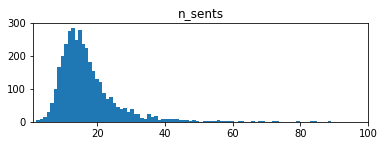

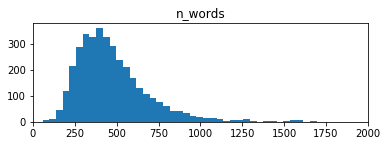

In [31]:
# Display data statistics
print(f'Number of document: {len(raw)}')

# count sentence in each document
count_sentences = lambda x: x.count('</s>')
raw['n_sents'] = raw['article'].map(count_sentences)

# count word in each docunent
count_words = lambda x: x.count(' ') + 1
raw['n_words'] = raw['article'].map(count_words)
 
# show data statistics
plt.subplot(2, 1, 1)
plt.xlim(1, 100)
plt.title('n_sents')
plt.hist(raw['n_sents'], bins=200)
plt.show()

plt.subplot(2, 1, 2)
plt.xlim(1, 2000)
plt.title('n_words')
plt.hist(raw['n_words'], bins=200)
plt.show()

In [0]:
# Save preprocessed data
save_df = pd.DataFrame()
save_df['id'] = raw['id']
save_df['article'] = raw['article'].map(lambda x: x.lstrip('<s> ').rstrip(' </s>').replace(' </s> <s>', ''))
save_df['headline'] = raw['headline'].map(lambda x: x.lstrip('<s> ').rstrip(' </s>').replace(' </s> <s>', ''))
save_df.to_csv(preprocessed_path, header=True, index=False)

## Cleaning by hand
The wikinews pages contain relative page's title and link. These are informative. However if these are the frist in pages, these are regard to noise for constructing a headline dataset. In this case, relative page's title move end of document. These may be good information to constract distant supervision dataset. The cleaned data is saved to `/content/drive/My Drive/wikinews-headline/cleaned-data.csv`.

In [7]:
# Load preprocessed data
path = '/content/drive/My Drive/wikinews-headline/cleaned-data.csv'
raw = pd.read_csv(path)
raw['article'] = raw['article'].apply(preprocess, use_start_pattern=False, is_document=True)
raw['headline'] = raw['headline'].apply(preprocess, is_document=False)
raw.tail()

,id,article,headline
3665,3665,<s> 東京 都 中野 区 の 中古 品 販売 の 「 ま ん だら け 」 で 、 アニメ...,<s> ま ん だらけ で の 「 鉄人 28 号 」 人形 窃盗 事件 容疑 者 を 逮捕...
3666,3666,<s> 各 情報 源 に よる と 、 9 月 3 日 午後 2 時 頃 、 菅 義 偉 官...,<s> 第 2 次 安倍 改造 内閣 発足 へ - 閣僚 名簿 </s>
3667,3667,<s> 8 月 5 日 ( 現地 時間 ) に 開幕 し た リオデジャネイロ オリンピック...,<s> 競泳 男女 ・ 体操 男子 決勝 進出 を 決める - リオデジャネイロ オリンピッ...
3668,3668,<s> 国際 陸上 競技 連盟 ( IAAF ) は 、 陸上 女子 走り幅跳び に 出場 ...,<s> ロシア 陸上 女子 走り幅跳び の ダリア ・ クリ シナ 選手 が 出場 禁止 へ...
3669,3669,<s> 8 月 5 日 ( 現地 時間 UTC - 3 ) に 開幕 し た リオデジャネイ...,<s> レスリング 女子 58 kg 級 ・ 伊 調 馨 選手 が 金メダル 獲得 、 女子...


## Construct a headline dataset

In [0]:
# Functions
def filter_sentences(doc, max_sents, max_tokens):
    sents = doc.lstrip('<s> ').rstrip(' </s>').split(' </s> <s>')
    while '' in sents:
        sents.pop(sents.index(''))

    if max_sents > 0:
        sents = sents[:max_sents] 
        count_words = lambda xs: sum([x.count(' ') + 1 for x in xs])
        n_words = count_words(sents)
        while n_words > max_tokens:
            max_sents -= 1
            sents = sents[:max_sents]
            n_words = count_words(sents)
        if n_words == 0:
            return None
    return ' '.join(sents)
    
def generate_dataset(df, max_sents=3, min_tokens=10, max_tokens=128):
    dataset = pd.DataFrame()
    dataset['id'] = df['id']
    dataset['article'] = df['article'].apply(filter_sentences, args=(max_sents, max_tokens, ))
    dataset['headline'] = df['headline'].map(lambda x: x.replace('<s>', '').replace('</s>', ''))
    dataset = dataset.dropna()
    
    dataset['n_words'] = dataset['article'].map(lambda x: x.count(' ') + 1)
    dataset = dataset[dataset['n_words'] > min_tokens]
    return dataset

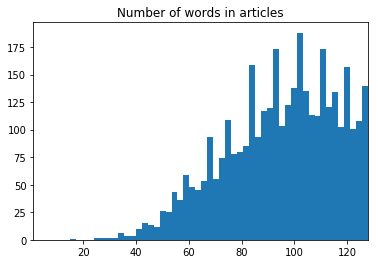

In [9]:
#@title Filtering
max_sents = 3 #@param {type: "number"}
min_tokens = 10 #@param {type: "number"}
max_tokens = 128 #@param {type: "number"}

max_tokens = max_tokens if max_sents > 0 else 2000

dataset = generate_dataset(
    raw,
    max_sents=max_sents,
    min_tokens=min_tokens,
    max_tokens=max_tokens
)


plt.xlim(1, max_tokens)
plt.title('Number of words in articles')
plt.hist(dataset['n_words'], bins=50) 
plt.show()

In [0]:
# Save a dataset
dataset = dataset[['id', 'article', 'headline']]

savedir = '/content/drive/My Drive/wikinews-headline/'
filename = f'jwhd-s{max_sents}-w{max_tokens}.csv' if max_sents > 0 else 'jwhd-full-article.csv'
path = os.path.join(savedir, filename)
dataset.to_csv(path)

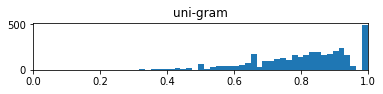

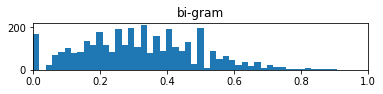

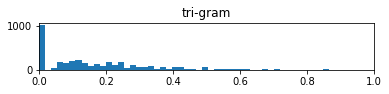

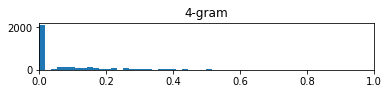

In [11]:
# Calculate n-gram overlap
def ngram_overlap(line, ngram):
    # from IPython.core.debugger import Pdb; Pdb().set_trace()
    src_ngram = list(nltk.ngrams(line['article'].split(' '), ngram))
    tgt_ngram = list(nltk.ngrams(line['headline'].split(' '), ngram))
    match_ngram = 0
    for ngram in tgt_ngram:
        if ngram in src_ngram:
            match_ngram += 1
    return match_ngram/len(tgt_ngram)


dataset['uni-gram'] = dataset.apply(ngram_overlap, axis=1, args=(1, ))
dataset['bi-gram'] = dataset.apply(ngram_overlap, axis=1, args=(2, ))
dataset['tri-gram'] = dataset.apply(ngram_overlap, axis=1, args=(3, ))
dataset['4-gram'] = dataset.apply(ngram_overlap, axis=1, args=(4, ))


# show data statistics
plt.subplot(4, 1, 1)
plt.xlim(0.0, 1.0)
plt.title('uni-gram')
plt.hist(dataset['uni-gram'], bins=50)
plt.show()

plt.subplot(4, 1, 2)
plt.xlim(0.0, 1.0)
plt.title('bi-gram')
plt.hist(dataset['bi-gram'], bins=50)
plt.show()

plt.subplot(4, 1, 3)
plt.xlim(0.0, 1.0)
plt.title('tri-gram')
plt.hist(dataset['tri-gram'], bins=50)
plt.show()

plt.subplot(4, 1, 4)
plt.xlim(0.0, 1.0)
plt.title('4-gram')
plt.hist(dataset['4-gram'], bins=50)
plt.show()


In [12]:
print(f"uni-gram: {dataset['uni-gram'].mean()*100:.4}%")
print(f"bi-gram: {dataset['bi-gram'].mean()*100:.4}%")
print(f"tri-gram: {dataset['tri-gram'].mean()*100:.4}%")
print(f"4-gram: {dataset['4-gram'].mean()*100:.4}%")

uni-gram: 80.79%
bi-gram: 32.2%
tri-gram: 16.34%
4-gram: 8.246%
